## Multivariate forecasting with the TRCRP Mixture

This tutorial notebook shows an example of using the TRCRP mixture for multivariate forecasting of flu data from the United States Center for Disease Control and Prevention.

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
rng = np.random.RandomState(3)

### Loading and plotting the flu data

We first load the data from `resources/cdc-usa.csv`. There are 56 columns containing flu rates (denoted as Rx.%ILI, meaning "incidence of influenza-like illness"); weather data (minimum temperature, maximum temperature, and precipitation); and tweet counts about the flu; for [US Federal Regions 1-10](https://en.wikipedia.org/wiki/List_of_regions_of_the_United_States).

In [4]:
frame = pd.read_csv('resources/cdc-usa.csv')
frame.columns

Index([u'Week', u'R01.%ILI', u'R02.%ILI', u'R03.%ILI', u'R04.%ILI',
       u'R05.%ILI', u'R06.%ILI', u'R07.%ILI', u'R08.%ILI', u'R09.%ILI',
       u'R10.%ILI', u'USA.%ILI', u'R01.Tmax', u'R01.Tmin', u'R01.prcp',
       u'R02.Tmax', u'R02.Tmin', u'R02.prcp', u'R03.Tmax', u'R03.Tmin',
       u'R03.prcp', u'R04.Tmax', u'R04.Tmin', u'R04.prcp', u'R05.Tmax',
       u'R05.Tmin', u'R05.prcp', u'R06.Tmax', u'R06.Tmin', u'R06.prcp',
       u'R07.Tmax', u'R07.Tmin', u'R07.prcp', u'R08.Tmax', u'R08.Tmin',
       u'R08.prcp', u'R09.Tmax', u'R09.Tmin', u'R09.prcp', u'R10.Tmax',
       u'R10.Tmin', u'R10.prcp', u'USA.Tmax', u'USA.Tmin', u'USA.prcp',
       u'R01.tweets', u'R02.tweets', u'R03.tweets', u'R04.tweets',
       u'R05.tweets', u'R06.tweets', u'R07.tweets', u'R08.tweets',
       u'R09.tweets', u'R10.tweets', u'USA.tweets'],
      dtype='object')

The measurements begin in week 40 of 1997...

In [5]:
frame.head()

,Week,R01.%ILI,R02.%ILI,R03.%ILI,R04.%ILI,R05.%ILI,R06.%ILI,R07.%ILI,R08.%ILI,R09.%ILI,...,R02.tweets,R03.tweets,R04.tweets,R05.tweets,R06.tweets,R07.tweets,R08.tweets,R09.tweets,R10.tweets,USA.tweets
0,1997.40,0.62,0.38,1.34,0.45,0.90,0.75,1.15,0.42,2.26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1997.41,0.82,0.23,1.53,0.39,1.08,0.88,0.65,0.72,2.57,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1997.42,1.23,0.13,2.19,0.47,1.06,0.90,0.61,0.25,2.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1997.43,1.62,0.22,1.70,0.17,1.00,1.06,0.69,0.42,2.64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1997.44,0.78,2.89,1.05,0.47,1.35,1.69,0.50,0.35,3.15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


... and end in week 29 of 2015.

In [6]:
frame.tail()

,Week,R01.%ILI,R02.%ILI,R03.%ILI,R04.%ILI,R05.%ILI,R06.%ILI,R07.%ILI,R08.%ILI,R09.%ILI,...,R02.tweets,R03.tweets,R04.tweets,R05.tweets,R06.tweets,R07.tweets,R08.tweets,R09.tweets,R10.tweets,USA.tweets
925,2015.25,0.55,1.40,0.99,0.64,0.90,1.23,0.47,0.77,1.03,...,631,544,786,825,810,2147,154,1020,229,7316
926,2015.26,0.60,1.35,1.00,0.63,0.82,1.24,0.31,0.63,1.07,...,589,525,822,694,694,751,111,1050,212,5677
927,2015.27,0.50,1.10,0.96,0.57,0.79,1.08,0.17,0.54,0.95,...,594,680,933,706,649,827,171,917,216,5869
928,2015.28,0.46,1.07,0.86,0.56,0.74,1.17,0.30,0.51,0.86,...,553,429,946,686,488,758,197,894,200,5362
929,2015.29,0.44,1.02,0.81,0.54,0.73,1.11,0.26,0.73,0.75,...,697,717,887,811,519,925,211,934,221,6122


In this tutorial we will create a population of three time series (flu rate, minimum temperature, and tweet counts) for US Region 6. We partition the dataset using data from 2008.01 through 2014.49 as the "training data", and data after 2014.50 as the "held-out" data.

In [7]:
df_r06_all = frame[['R06.%ILI','R06.Tmin','R06.tweets']]

In [8]:
DATE_START = 2008.0
DATE_END = 2014.50
weeks_observations = (DATE_START<frame['Week'])&(frame['Week']<DATE_END)
weeks_held_out = DATE_END<=frame['Week']

In [9]:
df_r06_observations = df_r06_all[weeks_observations]
df_r06_heldout = df_r06_all[weeks_held_out]

We now plot the three time series. Observe the cyclic behavior of the `R06.%ILI` and `R06.Tmin` variables, which obtain peaks (resp. troughs) during the yearly flu season. The `R06.tweets` time series is sparsely observed, since Twitter message counts are only available for the 2014 (and held-out 2015) flu seasons.

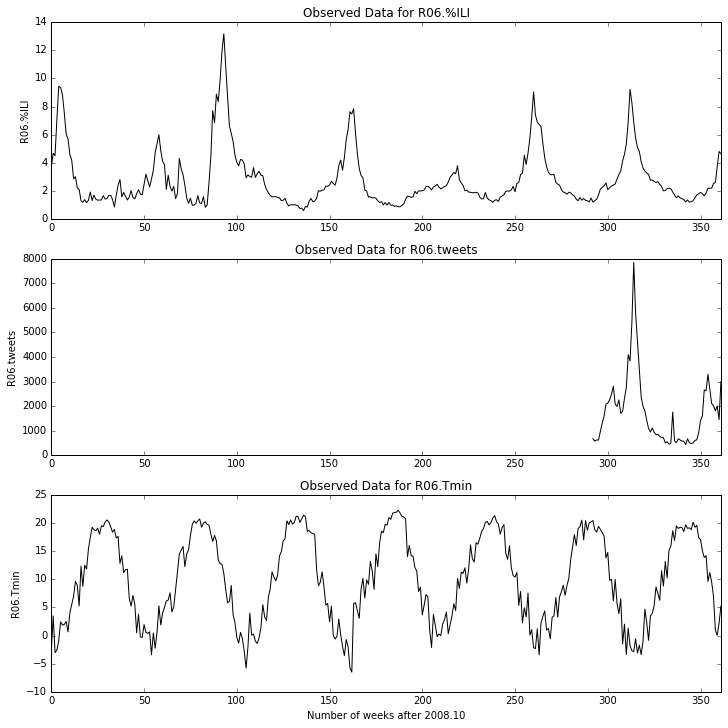

In [10]:
fig, axes = plt.subplots(nrows=3)
for ax, variable in zip(axes, ['R06.%ILI', 'R06.tweets', 'R06.Tmin']):
    xs = range(len(df_r06_observations))
    ax.plot(xs, df_r06_observations[variable], color='k')
    ax.set_ylabel(variable)
    ax.set_title('Observed Data for %s' % (variable,))
    ax.set_xlim([min(xs), max(xs)])
    
fig.set_size_inches(12,12)
axes[-1].set_xlabel('Number of weeks after 2008.10', fontweight='bold', labelsep=10);

### Creating a TRCRP mixture model, incorporating the data, and running inference

We now create a TRCRP mixture model for the time series. We use 8 chains for inference and a window size of 10 weeks. We then incorporate `df_r06_observations` data frame into the model, which contains the training data.

_Note_: Each chain will occupy one processor on your machine during parallel inference. For full parallelism, use no more chains than available number of processors (use `import multiprocessing; print multiprocessing.cpu_count()` to find the number of cpus on your machine).

In [11]:
from trcrpm import TRCRP_Mixture

In [12]:
model = TRCRP_Mixture(chains=8, lag=10, variables=df_r06_observations.columns, rng=rng)
model.incorporate(df_r06_observations)

500 steps of MCMC inference are followed by 50 steps of hyperparameter optimization. Depending on your machine, these steps should roughly take between one and three minutes to complete. The model's quality of inference and will typically greatly improve with both greater number of chains (set to 8 in the previous cell) and greater number steps of MCMC, at the expense of requiring more time and computational resources.

In [13]:
model.resample_all(steps=500)

Completed: 500 iterations in 70.335006 seconds.
Completed: 500 iterations in 74.787101 seconds.
Completed: 500 iterations in 75.679400 seconds.
Completed: 500 iterations in 75.807223 seconds.
Completed: 500 iterations in 76.198316 seconds.
Completed: 500 iterations in 82.884692 seconds.
Completed: 500 iterations in 111.765240 seconds.
Completed: 500 iterations in 112.982242 seconds.


In [14]:
model.resample_hyperparameters(steps=50);

Completed: 50 iterations in 28.228126 seconds.
Completed: 50 iterations in 33.401817 seconds.
Completed: 50 iterations in 35.197632 seconds.
Completed: 50 iterations in 35.568922 seconds.
Completed: 50 iterations in 38.349758 seconds.
Completed: 50 iterations in 40.754064 seconds.
Completed: 50 iterations in 57.614150 seconds.
Completed: 50 iterations in 63.230260 seconds.


### Forecasting the three time series jointly

We now use the `simulate` method to forecast the three time series at a set of probe points. We produce forecasts over a 10 week horizon, which is equal to the length of the window size.

In [15]:
probes = list(df_r06_heldout.index[:10])
samples = model.simulate(probes, model.variables, nsamples=500)

Some plotting functions.

In [16]:
def plot_predictions(simulations, variable, ax, states_from_chain=None):
    index = model.variables.index(variable)
    # Plot the observed data.
    x_observed = model.dataset.index
    y_observed = model.dataset.loc[:,variable]
    ax.plot(x_observed, y_observed, color='k', linewidth=1)
    ax.set_title('Forecasted Data for %s' % (variable,))
    # Plot confidence bands around the simulated data. 
    samples = simulations[:,:,index]
    ax.plot(probes, np.median(samples, axis=0), color='k', label='Mean Forecast')
    ax.fill_between(
        probes,
        np.percentile(samples, 15, axis=0),
        np.percentile(samples, 85, axis=0),
        color='gray',
        alpha=0.5)
    #  Plot the held-out data.
    ax.scatter(probes, df_r06_heldout.loc[probes,variable],
        color='r', marker='x', label='Held-out Data')
    # Add the legend.
    ax.legend(loc='upper left', handletextpad=0)
    ax.set_xlim([700,None])

We now plot the mean joint forecasts, along with error bars at the 15th to 85 percentile. The model correctly predicts (qualitatively) the upcoming seasonal peak. The held-out data, marked as red crosses, are generally well-aligned with the model's predictive uncertainty for the flu and tweets data.

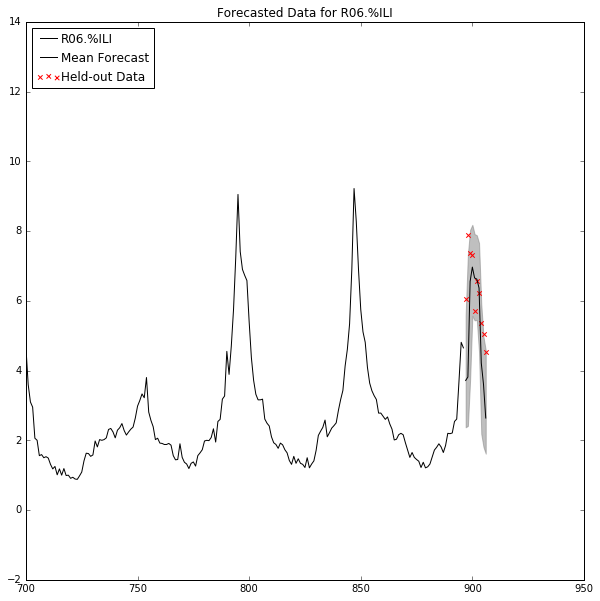

In [17]:
fig, ax = plt.subplots()
plot_predictions(samples, 'R06.%ILI', ax)
fig.set_size_inches(10,10)

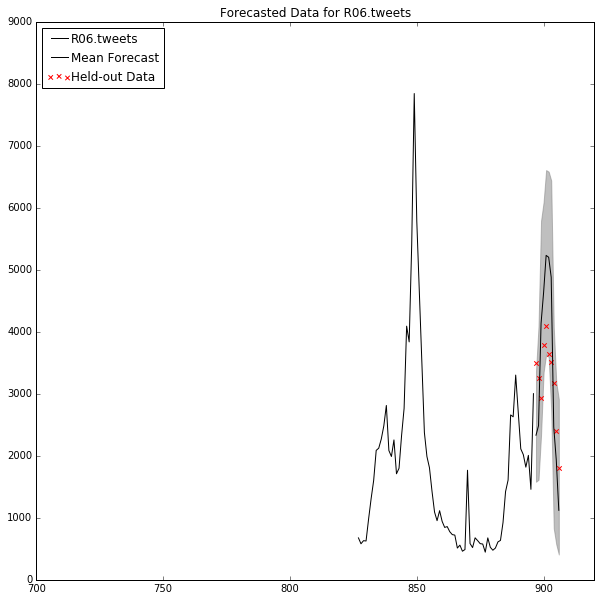

In [18]:
fig, ax = plt.subplots()
plot_predictions(samples, 'R06.tweets', ax)
fig.set_size_inches(10,10)

For the weather time series in the third plot, the model has wider uncertainty. (Can you explain why the predictive uncertainty is higher? Study the range of minimum temperatures that occured in the previous three flu seasons, and consider its impact on the model's ability to predict which of those regimes is applicable to the current year.)

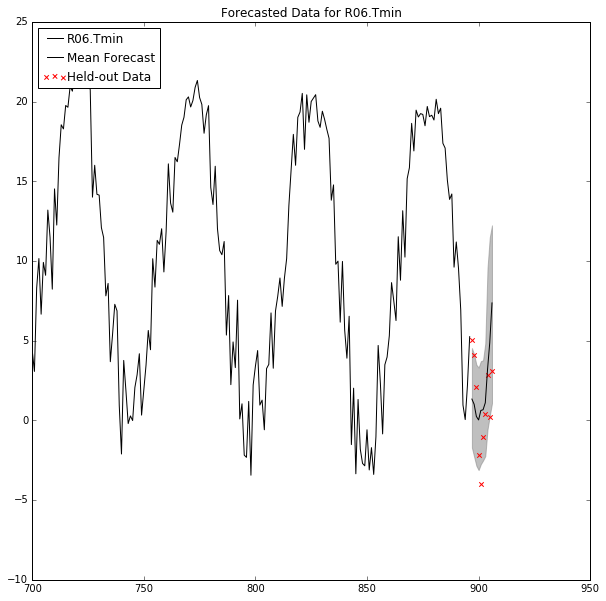

In [19]:
fig, ax = plt.subplots()
plot_predictions(samples, 'R06.Tmin', ax)
fig.set_size_inches(10,10)

As an exercise, use `incorporate` to add data from `df_r06_heldout` on a rolling basis. Does the quality of mean forecasts (and their uncertainties) improve as newer observations are added one-by-one into the model?